In [1]:
import numpy as np
import torch
from torch import nn  
import math
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import work.sw_csaf_Li5Relu_cluster.train_script as swcsaf
import work.sw_af_Li5Relu.train_script00 as swaf

In [3]:
plt.rcParams['font.size'] = '8'

In [4]:
from get_AM4_data_sw import get_AM4_data_sw
######################################################
# common functions to split the training and test data
from NNRTMC_lw_utils import  split_train_test_sample, \
draw_batches, data_std_normalization_sw, print_key_results, return_exp_dir

from diag_utils import batch_index_sta_end, pred_NN_batch,\
create_6tiles_sw,regrid_6tile2latlon

In [5]:
# def batch_index_sta_end(sample_size, batch_size):
#     n_batch = math.ceil(sample_size/batch_size)
#     batch_ind = []
#     sta=0
#     for i in range(n_batch-1):
#         end = sta + batch_size
#         batch_ind.append([sta, end])
#         sta = end
#     batch_ind.append([sta,sample_size])
#     return batch_ind
# def pred_NN_batch_sw(input_arr, output_arr, model, nor_para):
    
#     sample_size = input_arr.shape[0]
#     batch_size = 10000*100
#     batch_ind = batch_index_sta_end(sample_size, batch_size)
#     pred_out_array = np.empty_like(output_arr)
#     for sta, end in batch_ind:
#         # print(sta,end)
#         # move all data to GPU
#         input_torch = torch.tensor(input_arr[sta:end,:], dtype=torch.float32).to(device)
#         # get output from NN
#         pred_out_batch  = model.predict(input_torch).cpu().numpy() 
#         # denormalize
#         pred_out_array[sta:end,:] = pred_out_batch/nor_para['output_scale'] + nor_para['output_offset'] 
#         del input_torch # release GPU memory
#         torch.cuda.empty_cache()       
#     return pred_out_array

# # def pred_NN_batch_sw(input_arr, output_arr, model, nor_para):
# #     # move all data to GPU
# #     input_torch = torch.tensor(input_arr, dtype=torch.float32).to(device)
# #     # output_torch = torch.tensor(output_arr, dtype=torch.float32).to(device) 

# #     # get output from NN
# #     pred_out_array   = model.predict(input_torch).cpu().numpy() 
# #     # denormalize
# #     pred_out_array = pred_out_array/nor_para['output_scale'] + nor_para['output_offset'] 
    
# #     del input_torch, output_torch # release GPU memory
# #     torch.cuda.empty_cache()       
# #     return pred_out_array

# def create_6tiles_sw(ds_coords, predi, error, exp_dir, output_name): 
#     time    = ds_coords[0]['time']
#     pfull   = ds_coords[0]['pfull']
#     grid_yt = ds_coords[0]['grid_yt']
#     grid_xt = ds_coords[0]['grid_xt']
#     txy_size = time.shape[0]*grid_xt.shape[0]*grid_yt.shape[0]
#     if (predi.shape[0]/txy_size) !=6:
#         raise Exception('wrong size of output, pls check data dimension')
#     for i in range(6):
#         output_nn_ti = predi[txy_size*i:txy_size*(i+1)]
#         output_nn_ti = output_nn_ti.reshape(time.shape[0],
#                                             grid_yt.shape[0],
#                                             grid_xt.shape[0],
#                                             -1)
#         output_err_ti = error[txy_size*i:txy_size*(i+1)]
#         output_err_ti = output_err_ti.reshape(time.shape[0],
#                                               grid_yt.shape[0],
#                                               grid_xt.shape[0],
#                                               -1)
#         ds = xr.Dataset( 
#                         {'rsut':      (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,0]),
#                          'rsds':      (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,1]),
#                          'rsus':      (["time","grid_xt", "grid_yt"], output_nn_ti[:,:,:,2]),
#                          'tntrs':     (["time","grid_xt", "grid_yt", "pfull"], output_nn_ti[:,:,:,3:]),
#                          'err_rsut':  (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,0]),
#                          'err_rsds':  (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,1]),
#                          'err_rsus':  (["time","grid_xt", "grid_yt"], output_err_ti[:,:,:,2]),
#                          'err_tntrs': (["time","grid_xt", "grid_yt", "pfull"], output_err_ti[:,:,:,3:])
#                         },
#                         coords=ds_coords[i]
#                         )
#         var_4d_name = ['tntrs', 'err_tntrs']
#         var_3d_name = ['rsut', 'rsds','rsus',
#                        'err_rsut', 'err_rsds','err_rsus']
#         for _var in var_4d_name:
#             ds[_var] = ds[_var].transpose("time", "pfull","grid_yt", "grid_xt")
#         for _var in var_3d_name:
#             ds[_var] = ds[_var].transpose("time",  "grid_yt", "grid_xt")
#         encoding={}
#         for _var in list(ds.keys()):
#             encoding[_var] = {"dtype":"float32", "_FillValue":None} 
#         ds.to_netcdf(exp_dir+f'/NN_pred/{output_name}.tile{i+1}.nc', encoding=encoding)
#         var_list = list(ds.keys())
#         ds.close()
#     print('Finish create 6 tiles')
#     return var_list
# def regrid_6tile2latlon(var_list,exp_dir,root,output_name):
#     # run fregrid in subshell
#     var_list_str = ','.join(var_list)
#     cmd = f"cd {exp_dir}/NN_pred;"\
#          +f"cp {root}/regrid/* . ;"\
#          +f"bash run_fregrid.sh {output_name} {var_list_str};"\
#          +f"rm {output_name}.tile*"
#     tmp=subprocess.run([cmd], shell=True, capture_output=True)
#     if tmp.stderr.decode("utf-8") != '': 
#         raise Exception(tmp.stderr.decode("utf-8")) 
#     # print(tmp.stdout.decode("utf-8"))
#     regrid_file_path = exp_dir+f'/NN_pred/{output_name}.nc'
#     print('Finish regrid')
#     return regrid_file_path

In [6]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    ######################################################
    # set exp name and runs
    Exp_name = [
        'sw_csaf_Li5Relu_cluster',
        'sw_af_Li5Relu',
    ]
    Exp_name_model_dict = {
        'sw_csaf_Li5Relu_cluster': swcsaf,
        'sw_af_Li5Relu': swaf
    }
    sky_cond = {
        'sw_csaf_Li5Relu_cluster': 'csaf',
        'sw_af_Li5Relu': 'af',
    }
    work_dir = root+'/work/' 
    # file list from AM4 runs
    out_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
    inp_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [7]:
%%time
predi = {}
error = {}
NN_model = {}
ds_regrid = {}
day_inds = {}
for mo in Exp_name:
    ######################################################
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
    PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
    restart_data = torch.load(PATH_last)  # load exist results and restart training
    print(f'load: {PATH_last}')
    # read training dataset, nor_para, model parameteres
    nor_para = restart_data['nor_para']
    model_state_dict = restart_data['model_state_dict'] 
    
    # read data
    input_array_ori, output_array_ori, ds_coords = \
    get_AM4_data_sw(out_filelist, inp_filelist, condition=sky_cond[mo], 
                    month_sel = None, day_sel = list(np.arange(15,20)), return_coords=True) 
    # initialize model
    if mo == 'sw_af_Li5Relu':
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, input_array_ori.shape[1],model_state_dict)  
    else:
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, model_state_dict)  
    
    # remove data that rsdt == 0 (night, no shortwave transfer) 
    day_ind = np.argwhere(~np.isclose(input_array_ori[:,-1],0,rtol=1e-05, atol=1e-2,)).squeeze()
    day_inds[mo] = day_ind
    # normalize data via saved nor_para in restart file
    nor_para, input_array, output_array   = data_std_normalization_sw(input_array_ori[day_ind], output_array_ori[day_ind], nor_para)
    ######################################################
    # try NN on test dataset 
    predi[mo] = np.zeros_like(output_array_ori)
    predi[mo][day_ind] = pred_NN_batch(input_array, output_array, NN_model[mo], nor_para, device)
    error[mo] = predi[mo] - output_array_ori
    predi[mo][:,3:] = predi[mo][:,3:]*86400 # HR K/s >> K/day
    error[mo][:,3:] = error[mo][:,3:]*86400 # HR K/s >> K/day
    # create 6-tile files for output and regrid 
    NN_output_name = 'NN_20000101.fluxes' 
    subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
    var_list = create_6tiles_sw(ds_coords, predi[mo], error[mo], exp_dir, NN_output_name)
    regrid_file_path = regrid_6tile2latlon(var_list,exp_dir,root, NN_output_name)
    # open regridded file
    with  xr.open_dataset(regrid_file_path) as ds:
        ds_regrid[mo] = ds.load()
        

load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/sw_csaf_Li5Relu_cluster/restart.05.pth
Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [15, 16, 17, 18, 19] 
Reading data... finishied!
Total data size: 13787670
Finish create 6 tiles
Finish regrid
load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/sw_af_Li5Relu/restart.04.pth
Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [15, 16, 17, 18, 19] 
Reading data... finishied!
Total data size: 13787670
Finish create 6 tiles
Finish regrid
CPU times: user 22min 29s, sys: 1min 44s, total: 24min 14s
Wall time: 57min 52s


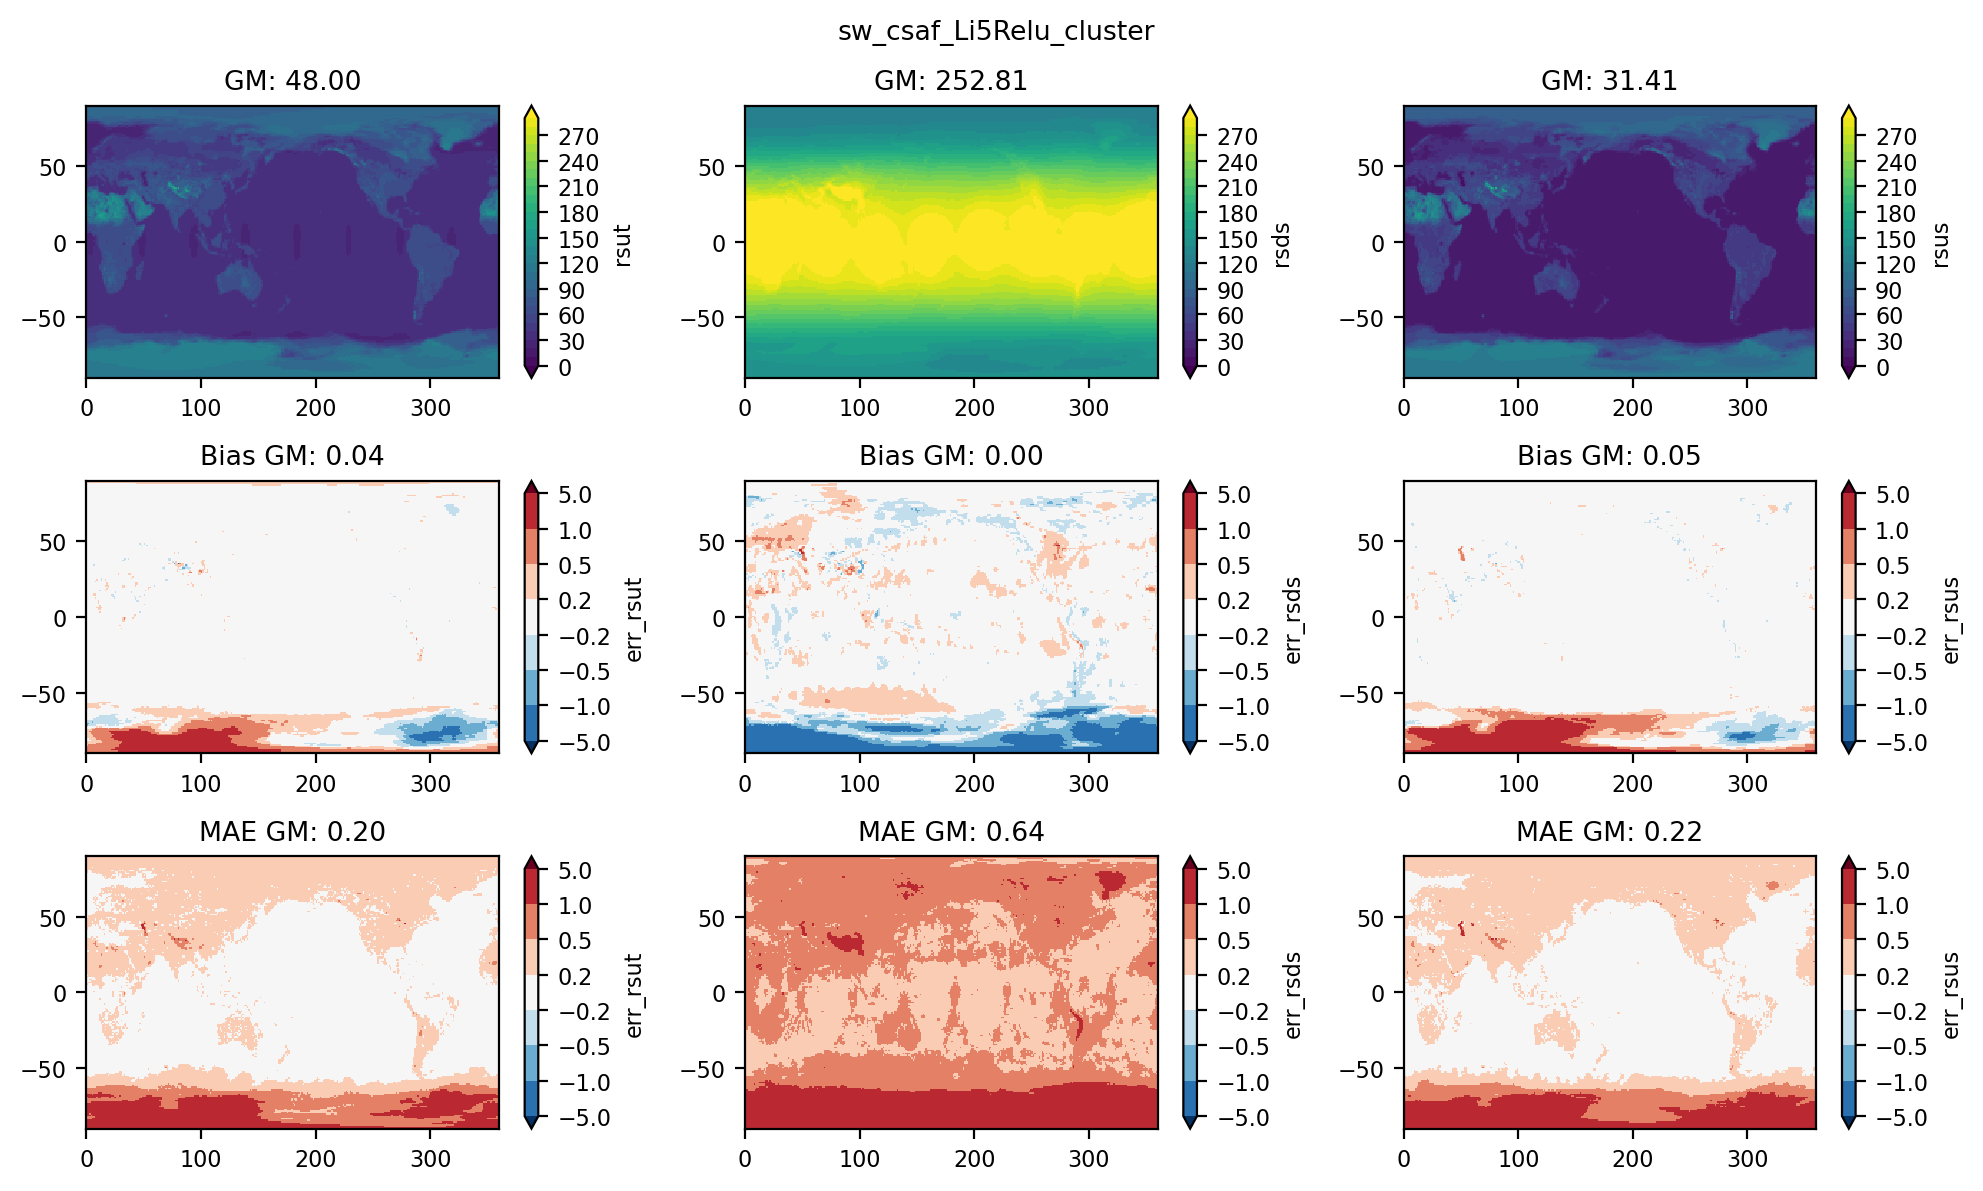

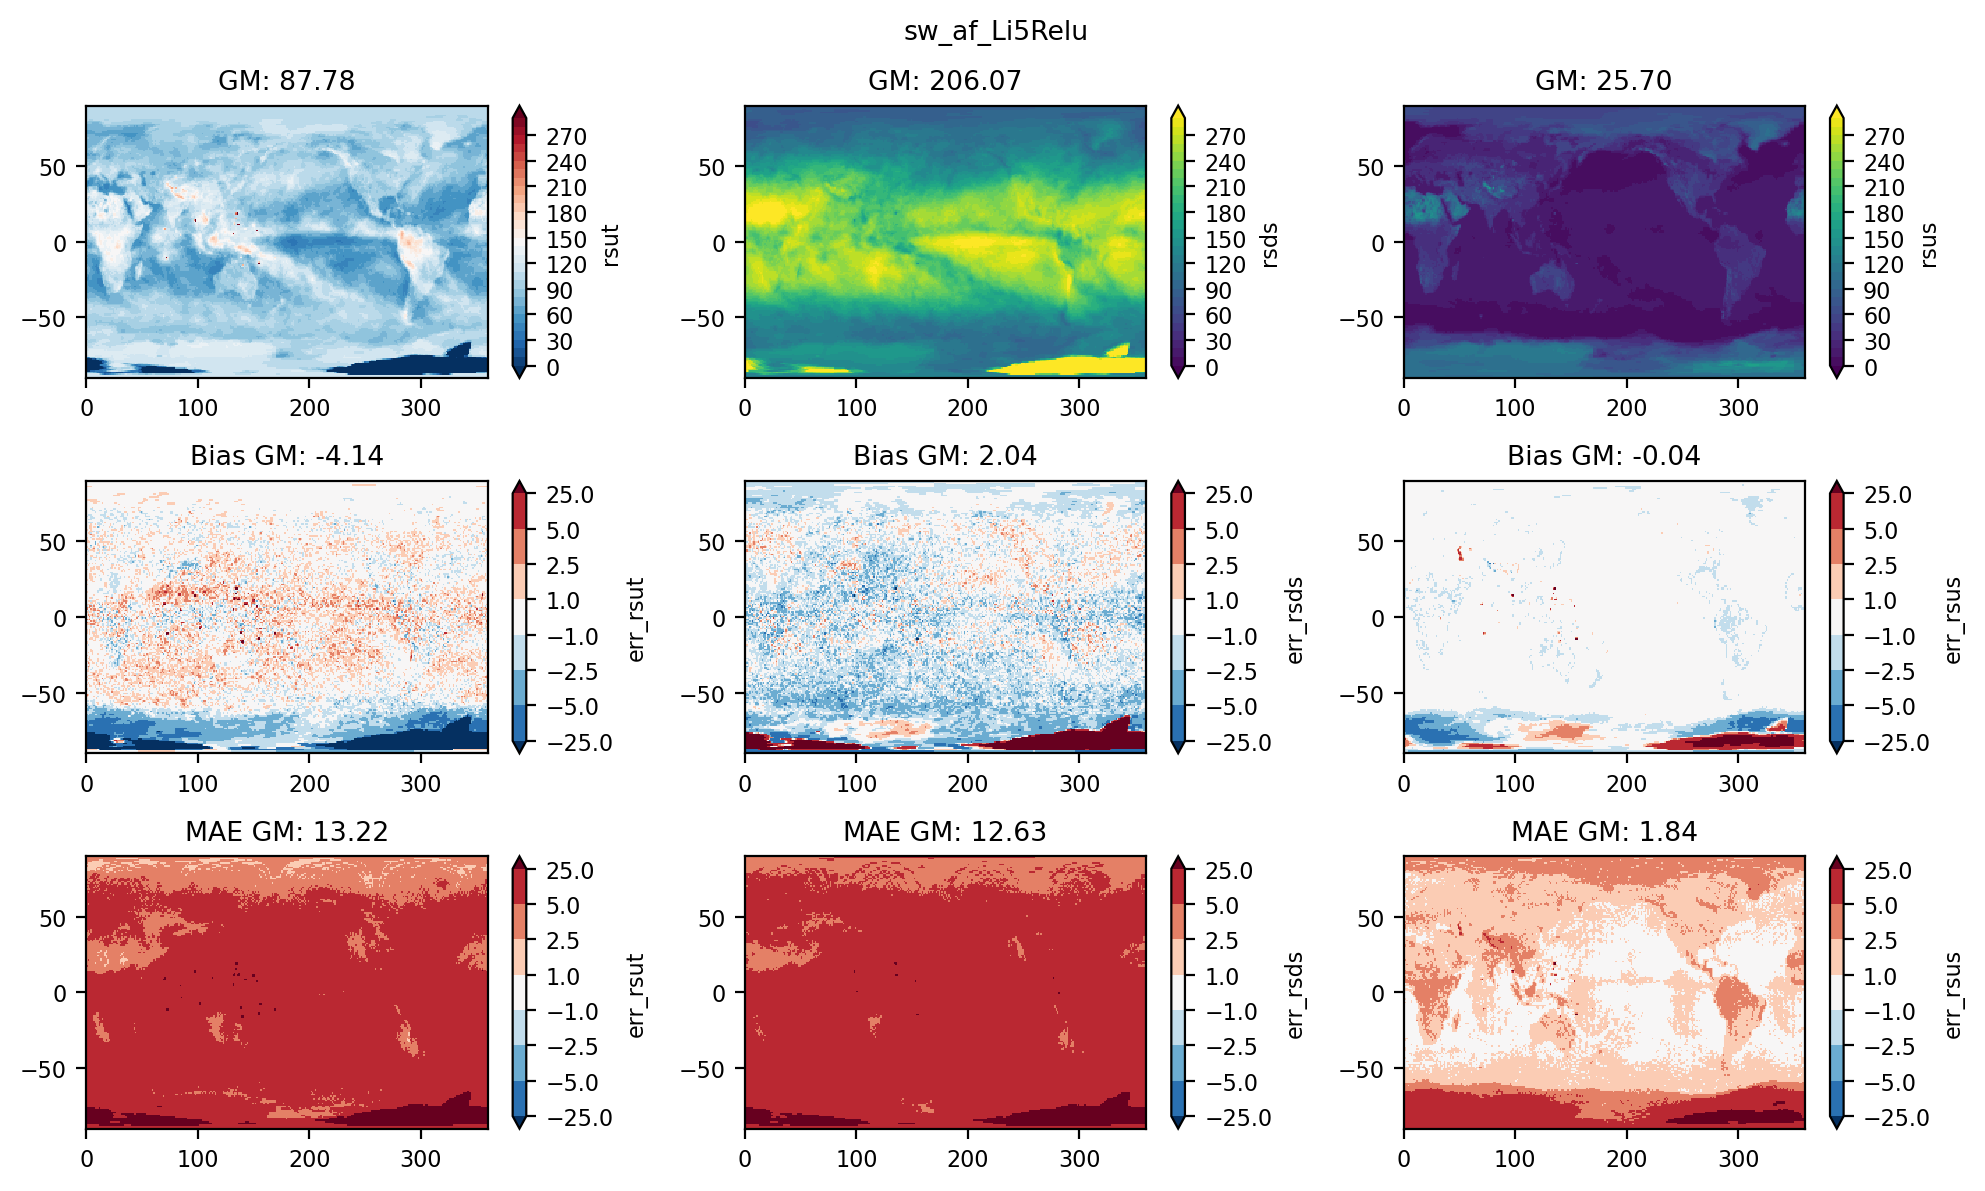

In [8]:
for mo in Exp_name:
    ds_plot = ds_regrid[mo].rename({'grid_yt':'lat', 'grid_xt':'lon'})
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,6),dpi=200)
    axs = axs.flatten()
    var1 = ['rsut','rsds','rsus']
    level = np.arange(0,300,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
    level = np.array([-5,-1,-0.5,-0.2,0.2,0.5,1,5])
    if mo == 'sw_af_Li5Relu': level = level*5
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()

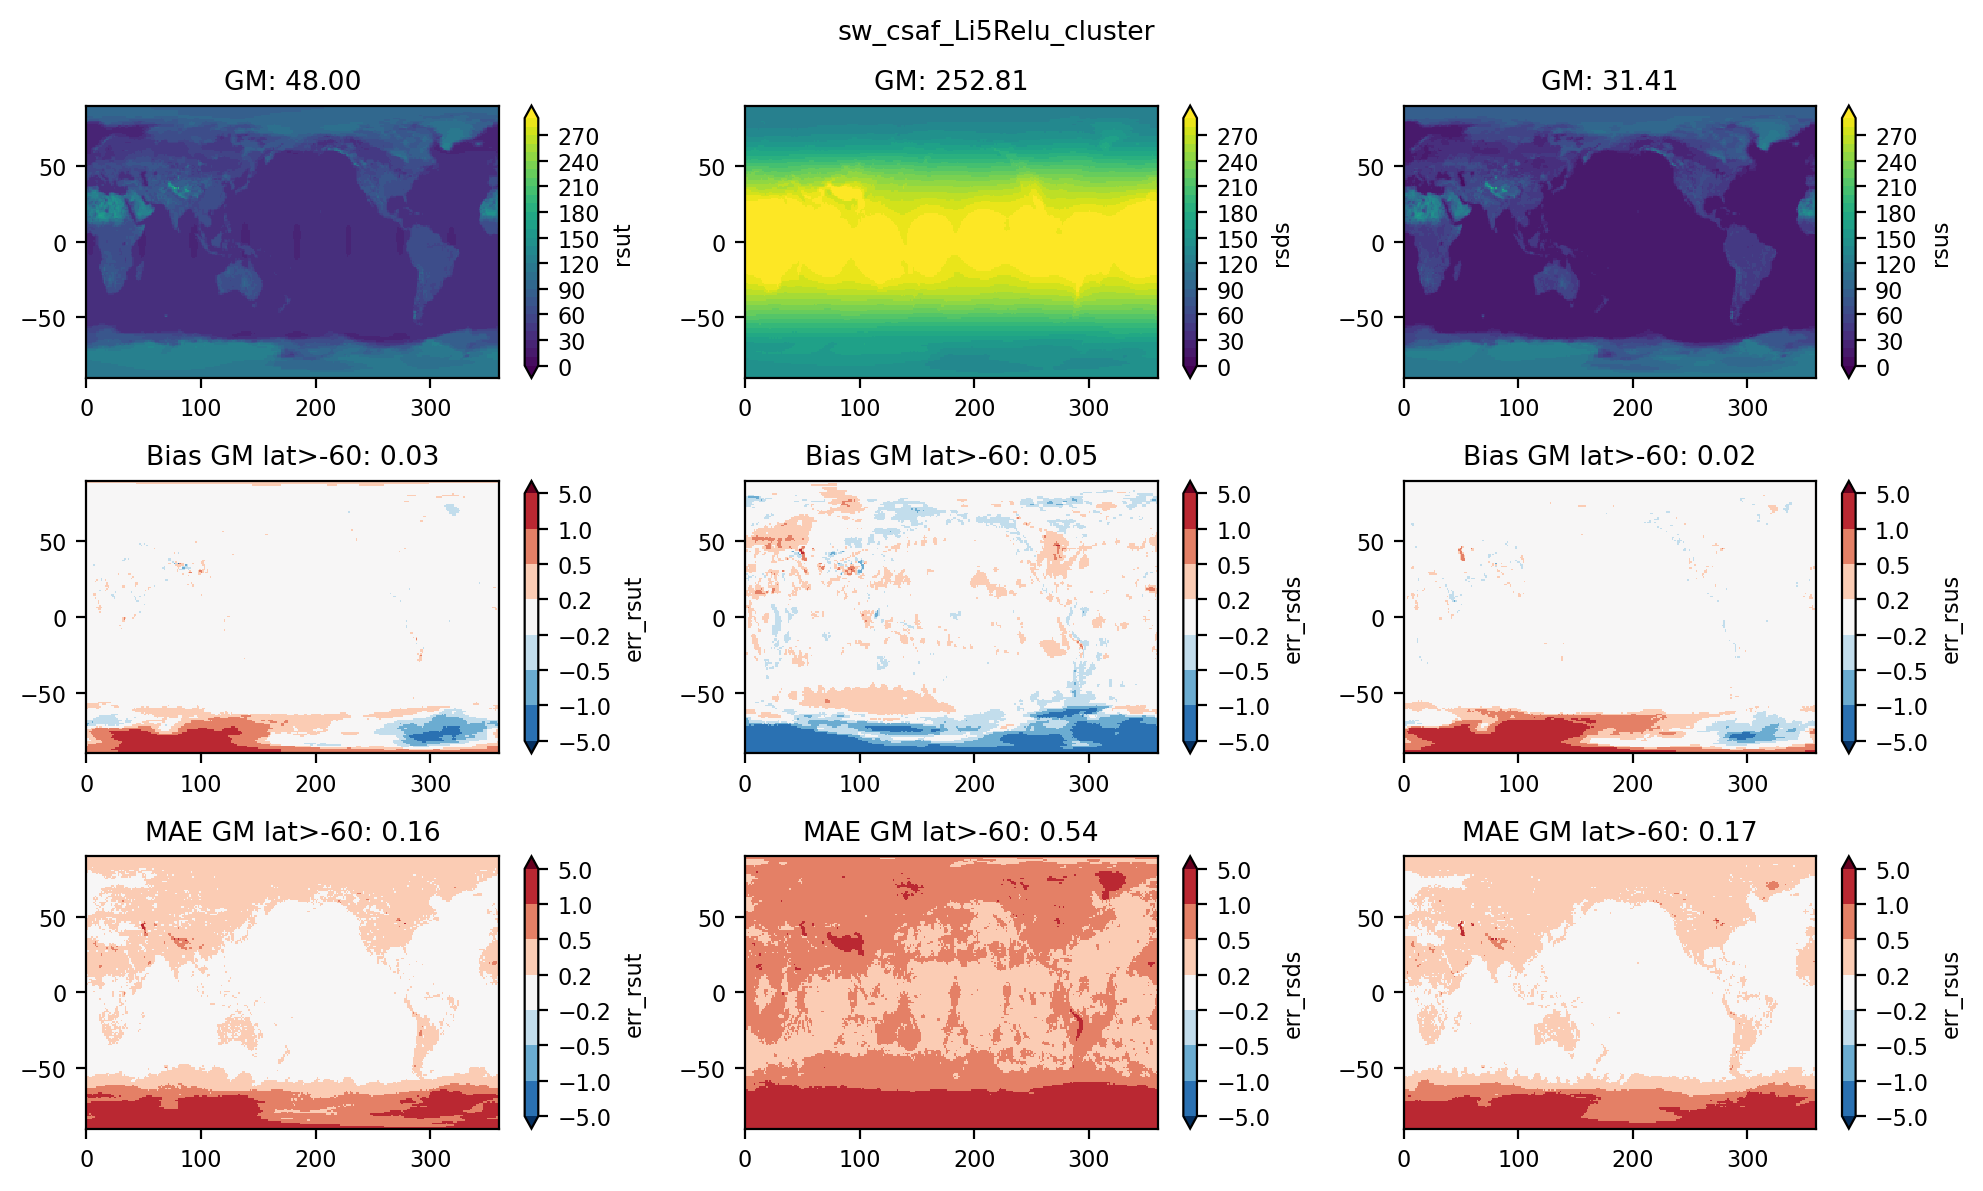

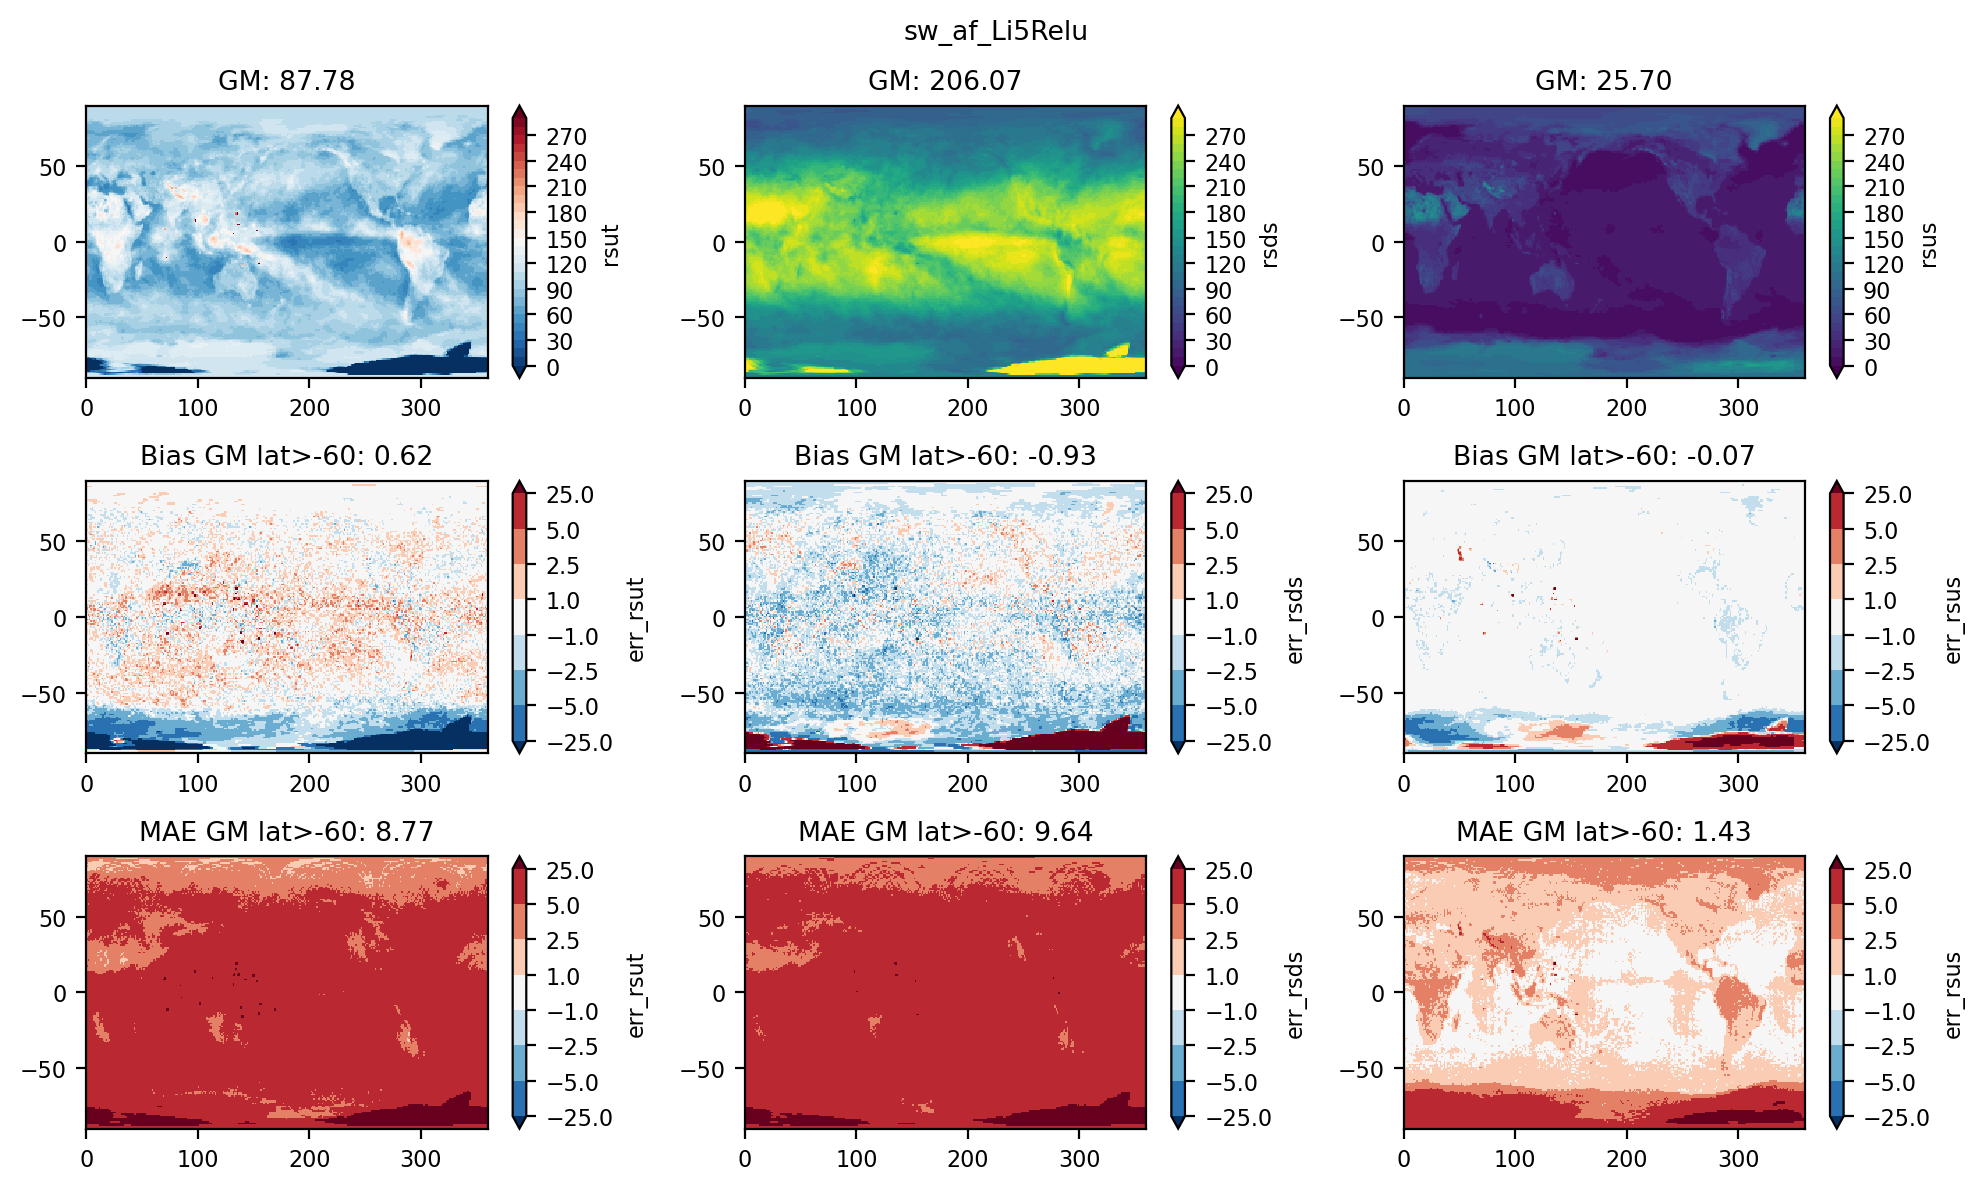

In [9]:
for mo in Exp_name:
    ds_plot = ds_regrid[mo].rename({'grid_yt':'lat', 'grid_xt':'lon'})
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,6),dpi=200)
    axs = axs.flatten()
    var1 = ['rsut','rsds','rsus']
    level = np.arange(0,300,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
    level = np.array([-5,-1,-0.5,-0.2,0.2,0.5,1,5])
    if mo == 'sw_af_Li5Relu': level = level*5
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'Bias GM lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'MAE GM lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()

In [10]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

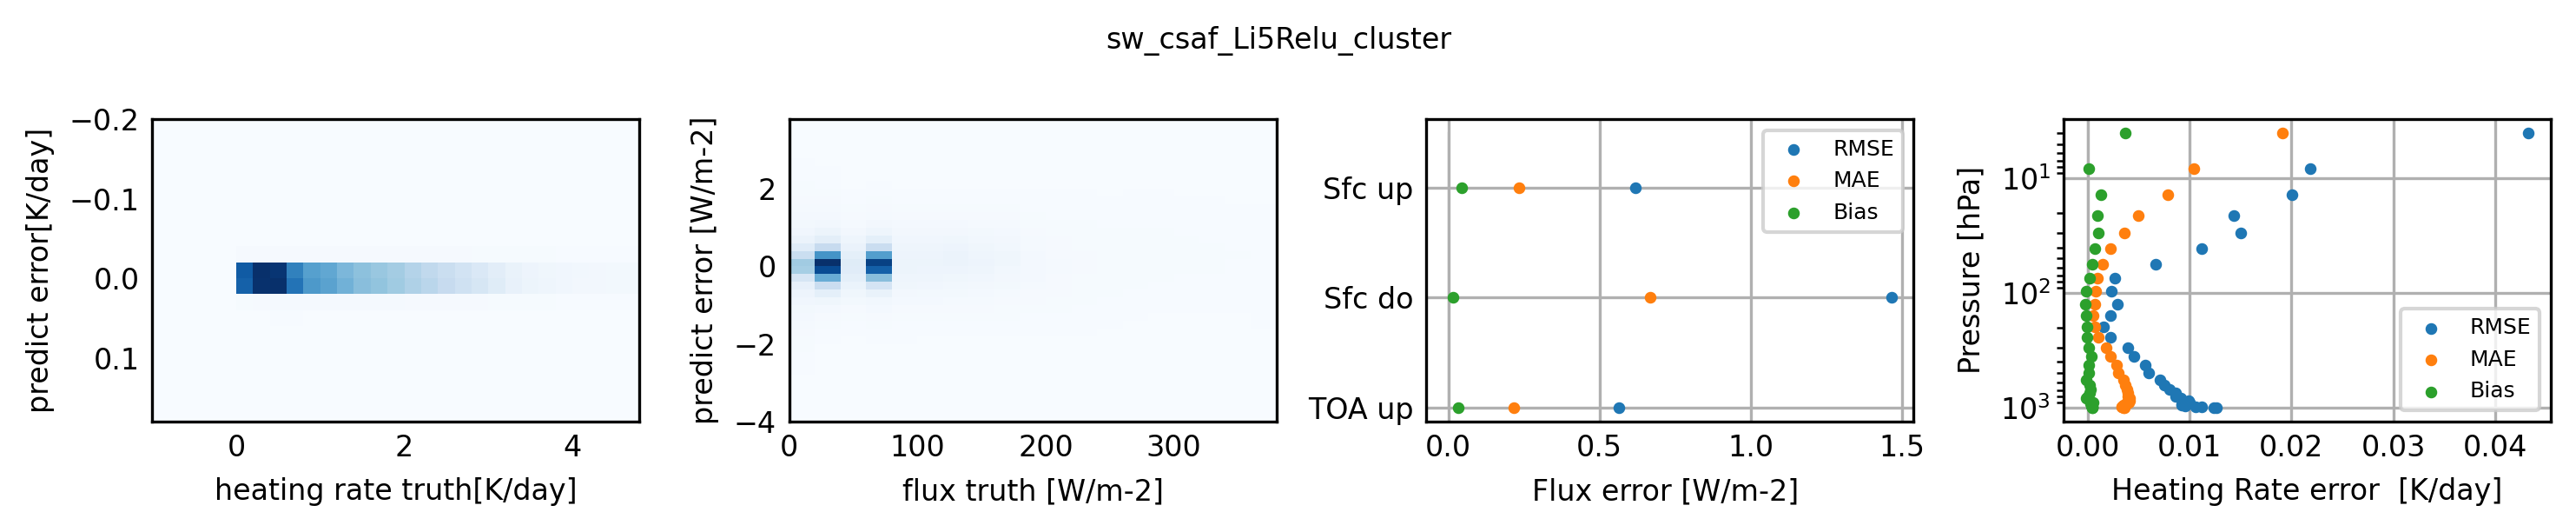

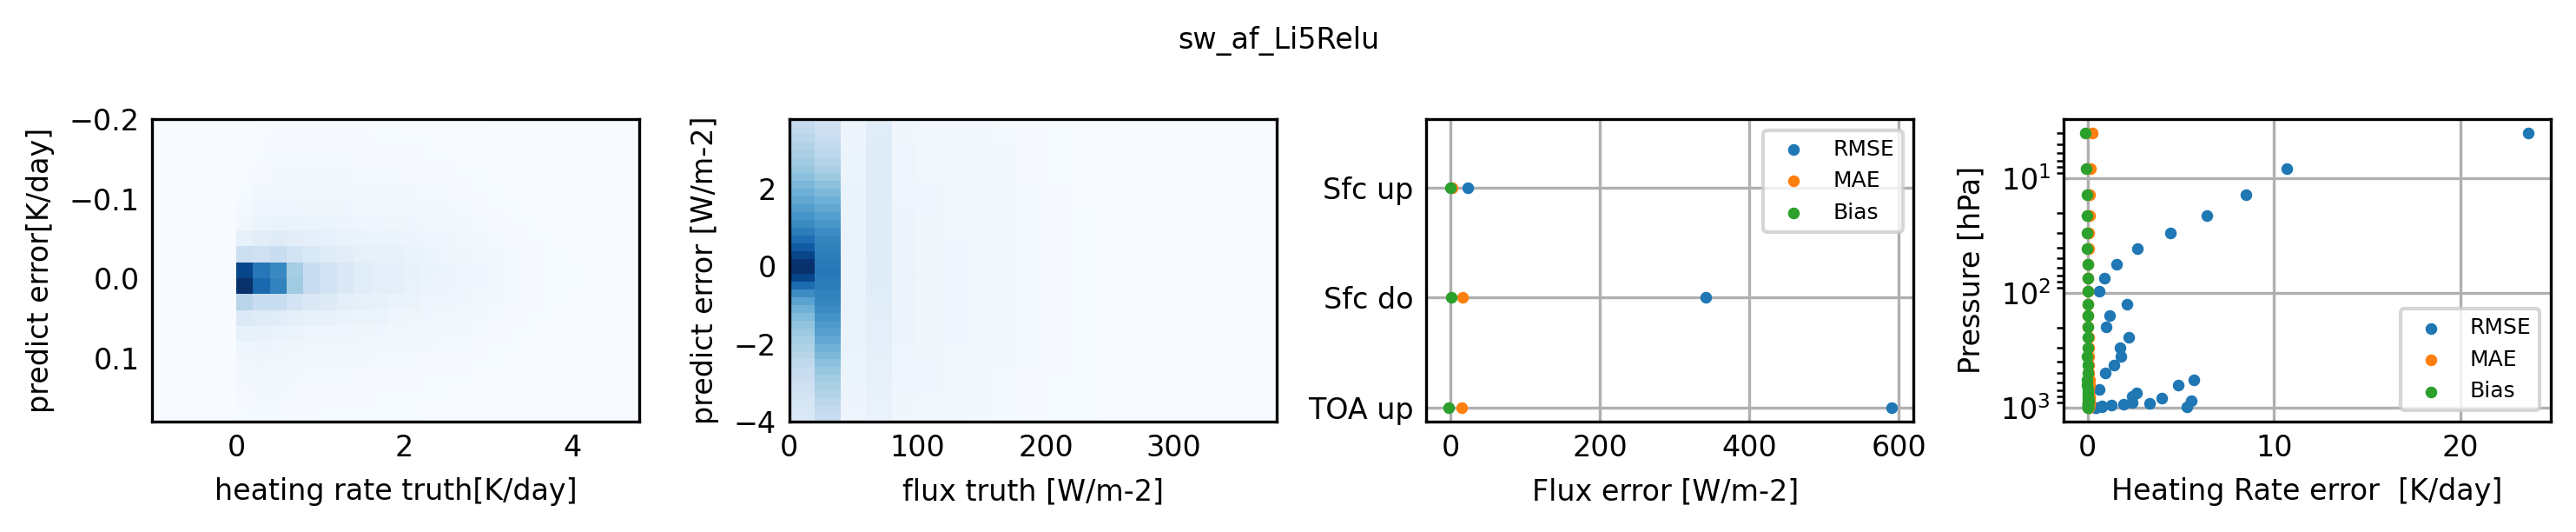

In [11]:
for i, mo in enumerate(Exp_name): 
    truth = predi[mo] - error[mo]
    RMSE = ((error[mo]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo]).mean(axis=0)
    bias = error[mo].mean(axis=0)
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,2),dpi=300) 
    axs=axs.flatten()
    ax1=axs[0] # heating rate
    ax2=axs[1] # surface flux
    ax3=axs[2] # error
    ax4=axs[3] # error
    # ax1.scatter(truth[:,3:].flatten(), bias[:,3:].flatten() , s=1) 
    ax1.hist2d(truth[day_ind,3:].flatten(), error[mo][day_ind,3:].flatten(), bins=(np.arange(-1, 5, 0.2), np.arange(-0.2, 0.2, 0.02)))
    # ax2.scatter(truth[:,:3].flatten(), bias[:,:3].flatten() , s=1) 
    ax2.hist2d(truth[day_ind,:3].flatten(), error[mo][day_ind,:3].flatten(), bins=(np.arange(0, 400, 20), np.arange(-4, 4, 0.2)))

    ax1.invert_yaxis()
    ax1.set_xlabel('heating rate truth[K/day]')
    ax1.set_ylabel('predict error[K/day]')
    ax2.set_xlabel('flux truth [W/m-2]')
    ax2.set_ylabel('predict error [W/m-2]')

    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'TOA up','Sfc do','Sfc up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m-2] ')
#     ax3.set_xlim([-0.1,1.2])

    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

(array([3.53607855e+08, 6.45489660e+07, 1.36851060e+07, 6.75683800e+06,
        4.01799000e+06, 2.83618300e+06, 1.38100900e+06, 1.32474400e+06,
        1.47046400e+06, 1.61797300e+06, 1.78099900e+06, 1.63215300e+06,
        3.27555000e+05, 5.24400000e+03, 1.40000000e+01, 9.00000000e+00,
        4.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.00000000e+00]),
 array([ 0.      ,  2.218216,  4.436432,  6.654648,  8.872864, 11.09108 ,
        13.309296, 15.527512, 17.745728, 19.963943, 22.18216 , 24.400375,
        26.618591, 28.836807, 31.055023, 33.27324 , 35.491455, 37.70967 ,
        39.927887, 42.146103, 44.36432 ], dtype=float32),
 <BarContainer object of 20 artists>)

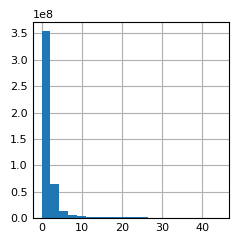

In [12]:
plt.hist(truth[day_ind,3:].flatten(),bins=20)

(array([9.722386e+06, 3.703941e+06, 2.773420e+05, 4.480500e+04,
        2.111700e+04, 1.050500e+04, 4.717000e+03, 1.819000e+03,
        6.310000e+02, 2.480000e+02, 8.800000e+01, 3.800000e+01,
        1.500000e+01, 9.000000e+00, 3.000000e+00, 3.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00]),
 array([ 0.       ,  1.8100865,  3.620173 ,  5.430259 ,  7.240346 ,
         9.050432 , 10.860518 , 12.670605 , 14.480692 , 16.290777 ,
        18.100864 , 19.910952 , 21.721037 , 23.531124 , 25.34121  ,
        27.151297 , 28.961384 , 30.77147  , 32.581554 , 34.391644 ,
        36.20173  ], dtype=float32),
 <BarContainer object of 20 artists>)

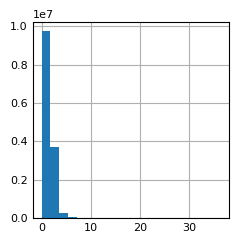

In [13]:
plt.hist(truth[day_ind,30].flatten(),bins=20)